In [1]:
%pip install "unstructured[md]" nltk langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **Single Document**

In [75]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain.document_loaders import TextLoader

# Load
markdown_path = "./Processed_Files_Introduction_to_End/CANopen_Integration_7012_V10_Mar11.md"
loader = TextLoader(markdown_path, autodetect_encoding=True)
doc = loader.load()
doc[0]

Document(metadata={'source': './Processed_Files_Introduction_to_End/CANopen_Integration_7012_V10_Mar11.md'}, page_content='# <span id="page-6-0"></span>**5 Introduction**\n\n# <span id="page-6-1"></span>**5.1 Overview**\n\nThis guideline describes the concepts for the integration of fieldbus systems into PROFINET IO. The following aspects are considered:\n\n- Cyclic process data\n- Acyclic parameters\n- Diagnostics\n- Alarms\n- Temporal behavior / Synchronization\n- Startup behavior\n- Engineering\n\nA PROFINET IO Linking Device consists of at least two communication channels, one PROFINET IO Device and at least one CANopen Device that shall support SDO Client Functionality and may additionally support NMT Master functionality and a PDO producer / consumer. The application within the Linking Device is the mapper between the PROFINET IO services [2] and the services of [5]. This specification describes the mapping of a PROFINET IO-Device to a set of CANopen Devices.\n\n[Figure 1](#page-

In [76]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]

# MD splits
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=False
)
md_header_splits = markdown_splitter.split_text(doc[0].page_content)
md_header_splits

[Document(metadata={'Header 1': '<span id="page-6-0"></span>**5 Introduction**'}, page_content='# <span id="page-6-0"></span>**5 Introduction**'),
 Document(metadata={'Header 1': '<span id="page-6-1"></span>**5.1 Overview**'}, page_content='# <span id="page-6-1"></span>**5.1 Overview**  \nThis guideline describes the concepts for the integration of fieldbus systems into PROFINET IO. The following aspects are considered:  \n- Cyclic process data\n- Acyclic parameters\n- Diagnostics\n- Alarms\n- Temporal behavior / Synchronization\n- Startup behavior\n- Engineering  \nA PROFINET IO Linking Device consists of at least two communication channels, one PROFINET IO Device and at least one CANopen Device that shall support SDO Client Functionality and may additionally support NMT Master functionality and a PDO producer / consumer. The application within the Linking Device is the mapper between the PROFINET IO services [2] and the services of [5]. This specification describes the mapping of a P

In [77]:
# Char-level splits
chunk_size = 1000
chunk_overlap = 200
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)

# Split
splits = text_splitter.split_documents(md_header_splits)
splits

[Document(metadata={'Header 1': '<span id="page-6-0"></span>**5 Introduction**'}, page_content='# <span id="page-6-0"></span>**5 Introduction**'),
 Document(metadata={'Header 1': '<span id="page-6-1"></span>**5.1 Overview**'}, page_content='# <span id="page-6-1"></span>**5.1 Overview**  \nThis guideline describes the concepts for the integration of fieldbus systems into PROFINET IO. The following aspects are considered:  \n- Cyclic process data\n- Acyclic parameters\n- Diagnostics\n- Alarms\n- Temporal behavior / Synchronization\n- Startup behavior\n- Engineering  \nA PROFINET IO Linking Device consists of at least two communication channels, one PROFINET IO Device and at least one CANopen Device that shall support SDO Client Functionality and may additionally support NMT Master functionality and a PDO producer / consumer. The application within the Linking Device is the mapper between the PROFINET IO services [2] and the services of [5]. This specification describes the mapping of a P

## **All Documents**

In [78]:
import glob
import os

from langchain_core.documents import Document

In [79]:
# 1. Path/pattern for markdown files
folder_path = "./Processed_Files_Introduction_to_End/*.md"

# 2. Parameters for the Header Splitter
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]
markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, 
    strip_headers=False
)

# 3. Parameters for the character-level splitter
chunk_size = 1000
chunk_overlap = 200
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap
)

# Final list for all splits from all files
all_splits = []

for file_path in glob.glob(folder_path):
    # a) Load the file as raw text (preserving Markdown)
    loader = TextLoader(file_path, autodetect_encoding=True)
    docs = loader.load()  # usually returns a list [Document]
    
    # b) For each Document, perform two splits
    for doc in docs:
        md_header_splits = markdown_splitter.split_text(doc.page_content)
        splits = text_splitter.split_documents(md_header_splits)
        
        # c) Use the base file name as "name_file" (without the path and without extension)
        filename = os.path.splitext(os.path.basename(file_path))[0]

        for splitted_doc in splits:
            splitted_doc.metadata["name_file"] = filename
            # Optionally, remove the original "source" if not needed:
            # splitted_doc.metadata.pop("source", None)

        all_splits.extend(splits)

In [ ]:
min_size = 1000  # Minimum size for the merged chunks
merged_documents = []  # List to store merged documents
buffer_content = ""
buffer_metadata = {}

for doc in all_splits:
    text = doc.page_content.strip()  # remove extra spaces if necessary
    # If there is no content accumulated in the buffer and the chunk is small,
    # initialize the buffer with this chunk.
    if not buffer_content and len(text) < min_size:
        buffer_content = text
        buffer_metadata = doc.metadata
    # If there is already content in the buffer, concatenate it with the current chunk.
    elif buffer_content:
        buffer_content += "\n" + text  # add a line break to separate the texts
        # When the buffer reaches or exceeds the minimum size, create a Document
        if len(buffer_content) >= min_size:
            merged_documents.append(
                Document(page_content=buffer_content, metadata=buffer_metadata)
            )
            buffer_content = ""
            buffer_metadata = {}
    # If the current chunk is already large enough and there is nothing in the buffer, add it directly.
    elif len(text) >= min_size:
        merged_documents.append(Document(page_content=text, metadata=doc.metadata))

# If there is remaining content in the buffer, add it as well.
if buffer_content:
    merged_documents.append(Document(page_content=buffer_content, metadata=buffer_metadata))

# Example of printing the results:
for i, document in enumerate(merged_documents):
    print(f"Document {i+1}:")
    print("Metadata:", document.metadata)
    print("Content (first 200 characters):", document.page_content[:200])
    print("-" * 50)

In [ ]:
print(f"Generated {len(all_splits)} chunks in total.")

In [ ]:
print(f"Generated {len(merged_documents)} chunks in total.")

In [83]:
merged_documents

# **RAG**

In [1]:
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain_ollama import ChatOllama
from typing_extensions import TypedDict
from typing import List
from langchain.schema import Document
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from pprint import pprint
from langchain_core.prompts import ChatPromptTemplate

In [3]:
# Example embeddings (you can use OpenAIEmbeddings or another)
embeddings = OllamaEmbeddings(model="nomic-embed-text:latest")

# Create an in-memory local vector store (FAISS)
# vector_store = FAISS.from_documents(merged_documents, embedding=embeddings)

In [4]:
# vector_store.save_local("faiss_index")

In [5]:
# # Example embeddings (you can use OpenAIEmbeddings or another)
embeddings = OllamaEmbeddings(model="nomic-embed-text:latest")

# # Create an in-memory local vector store (FAISS)
# vector_store = FAISS.from_documents(splits, embedding=embeddings)

# vector_store.save_local("faiss_index")

In [6]:
vector_store = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

In [7]:
# Example of an LLM
llm = ChatOllama(temperature=0, model="gemma3:12b")

In [8]:
template = """You are an AI language model assistant that understands PROFIBUS-related documents and specifications in the context of industrial automation.

IMPORTANT: FOCUS **ONLY ON PROFIBUS**.  
DO NOT INCLUDE **ANYTHING** ABOUT PROFINET.  
DO NOT INCLUDE **ANYTHING** ABOUT CANOPEN.  
THIS IS **ONLY** ABOUT PROFIBUS.  
REPEAT: **PROFIBUS ONLY**.  
IGNORE ALL OTHER PROTOCOLS.

### Instructions:
- Answer in a clear, informative, and technically accurate manner.
- Provide a **complete and relevant explanation**, but avoid excessive detail.
- Start with a **direct answer**, then expand with useful clarification, examples, or context if appropriate.
- Avoid unnecessary filler or repetition.
- Answer **in the same language as the question**.
- You can say "I don't know" if you don't know the answer.

### Now answer the following:

Question: {question}

Context: {context}

Answer (in the language of the question):  
"""

prompt = ChatPromptTemplate.from_template(template)

# llm = ChatOllama(temperature=0, model="qwen2:7b-instruct")

In [9]:
question = "Qual é o objetivo de um dispositivo Linking na integração de CANopen com PROFINET IO?"

In [10]:
def generate_hypothetical_document(question: str) -> str:
    """
    Generates a hypothetical, technically accurate document in English for the given question,
    to be used in vector-based retrieval systems. The result must be focused, factual, and domain-specific.
    """
    hyde_template = (
        "You are an AI assistant specialized in industrial automation, communication protocols, and control networks. "
        "Your task is to generate a detailed and technically accurate hypothetical answer that could appear in a knowledge base, "
        "technical documentation, or white paper related to industrial networking. Follow these strict instructions:\n"
        "1. The response must ONLY contain the hypothetical document text—no commentary, notes, explanations, or formatting.\n"
        "2. The content must be written in English and must not include greetings or apologies.\n"
        "3. The text should be informative, concise, and focused on answering the question using domain-relevant terminology.\n"
        "4. Do not restate the question. Just provide the content.\n\n"
        "Question: {question}\n\n"
        "Hypothetical Document:"
    )

    prompt_hyde = ChatPromptTemplate.from_template(hyde_template)
    messages = prompt_hyde.format(question=question)

    hyde_llm = ChatOllama(model="gemma3:12b", temperature=0.7)

    # Generate the hypothetical document
    response = hyde_llm.invoke(messages)

    # Extract and clean content
    if hasattr(response, "content"):
        return response.content.strip()
    else:
        return response.strip()


In [12]:
generate_hypothetical_document(question)

'## Linking Device Functionality in CANopen-to-PROFINET IO Integration\n\nThe primary function of a Linking Device in a CANopen-to-PROFINET IO integration is to bridge the communication domains and translate data between the two distinct network protocols. It acts as a gateway, enabling interoperability between CANopen networks, commonly found in lower-level automation devices like drives, I/O modules, and sensors, and PROFINET IO networks, frequently employed for higher-level control and supervisory functions.\n\nSpecifically, the Linking Device performs the following critical tasks:\n\n*   **Protocol Translation:** The device converts CANopen communication frames, utilizing the CAN physical layer and CANopen object dictionary (OD) for data representation, into PROFINET IO packets, which utilize the Ethernet physical layer and PROFINET IO device profiles. This includes mapping CANopen process data objects (PDOs) to PROFINET IO input/output data.\n*   **Data Mapping & Transformation:**

In [13]:
retriever = vector_store.as_retriever()

In [14]:
class State(TypedDict):
    question: str           # User's question
    hypothetical_answer: str # Hypothetical document generated for retrieval
    context: List[Document] # Documents returned by the retrieve function
    answer: str             # Final answer from the LLM

def generate_hypothetical_document(question: str) -> str:
    """
    Generates an ideal hypothetical answer for the given question to be used for document retrieval.
    The answer must be solely the hypothetical document, with no additional commentary, explanations, or formatting.
    """
    hyde_template = (
        "You are an expert assistant. Given the following question, generate a comprehensive hypothetical answer "
        "that will serve as an ideal document for information retrieval. Follow these strict rules:\n"
        "1. Do not include any extra commentary, headers, or notes. Your response must be only the hypothetical document text.\n"
        "2. Do not include greetings, apologies, or any text before or after the answer.\n"
        "3. The answer should be concise, factual, and focused solely on answering the question.\n\n"
        "Question: {question}\n\n"
        
        "Hypothetical Answer (in english. ONLY the text, nothing else):"
    )
    prompt_hyde = ChatPromptTemplate.from_template(hyde_template)
    messages = prompt_hyde.format(question=question)

    hyde_llm = ChatOllama(model="gemma3:12b", temperature=0.7)
    
    # Utilize the LLM to generate the hypothetical document.
    response = hyde_llm.invoke(messages)
    
    # If the response is wrapped in an AI message, extract its content.
    if hasattr(response, "content"):
        return {"hypothetical_answer": response.content.strip()}
    else:
        return {"hypothetical_answer": response.strip()}

def retrieve(state: State):
    """
    Retrieval step: performs a similarity search in the vector_store
    and returns the documents that will serve as context for the answer.
    
    Args:
        state (State): The current state containing the user's question.
    
    Returns:
        dict: A dictionary with the key "context" that will be added to the state.
    """
    retrieved_docs = retriever.invoke(state["hypothetical_answer"])
    # Returns a dictionary with the key "context"
    return {"context": retrieved_docs}

def generate(state: State):
    """
    Generation step: formats the 'context' and the 'question' into a prompt,
    calls the LLM, and obtains the final answer.
    
    Args:
        state (State): The current state containing the user's question and the retrieved context.
    
    Returns:
        dict: A dictionary with the key "answer" containing the final answer from the LLM.
    
    Raises:
        ValueError: If the response format from the LLM is unexpected.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    
    response = llm.invoke(messages)  # or llm(messages), depending on your setup

    # If the response is of type AIMessage and has the attribute 'content', use it:
    if hasattr(response, "content"):
        return {"answer": response.content}
    elif isinstance(response, str):
        return {"answer": response}
    else:
        raise ValueError("Unexpected response format.")

In [15]:
# Build the application graph:
graph_builder = StateGraph(State).add_sequence([generate_hypothetical_document, retrieve, generate])
graph_builder.add_edge(START, "generate_hypothetical_document")
graph_builder.add_edge("generate_hypothetical_document", "retrieve")
graph_builder.add_edge("retrieve", "generate")

# Compile into a callable "graph" object
graph = graph_builder.compile()

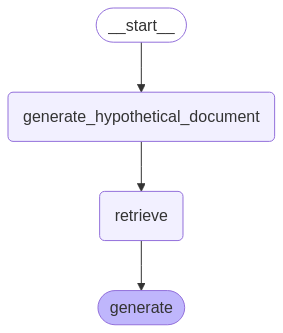

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

## **Queries**

In [ ]:
import re
from pprint import pprint

def clean_answer(answer: str) -> str:
    """
    Cleans the generated answer by removing unnecessary information and formatting.
    
    Args:
        answer (str): The raw answer generated by the LLM.
        
    Returns:
        str: The cleaned answer, formatted for better readability.
    """

    # Remove logs such as INFO:langchain...
    cleaned = re.sub(r'INFO:.*?(\n|$)', '', answer)

    # Extract the value of the 'answer' key if it's a dictionary string
    match = re.search(r"'answer':\s*([\"'])(.*?)\1", cleaned, re.DOTALL)
    if match:
        cleaned = match.group(2)

    # Remove markdown bold formatting **text**
    cleaned = re.sub(r"\*\*(.*?)\*\*", r"\1", cleaned)

    # Remove duplicate spaces and normalize line breaks
    cleaned = re.sub(r'\n{3,}', '\n\n', cleaned)
    cleaned = re.sub(r'[ \t]+$', '', cleaned, flags=re.MULTILINE)

    return cleaned.strip()

def clean_context(context):
    """
    Simplifies the context by extracting relevant metadata and limiting content length.
    
    Args:
        context (List[Document]): The list of documents retrieved as context.
        
    Returns:
        List[dict]: A simplified list of dictionaries containing the document ID and a snippet of the content.
    """
    
    return [
        {
            "id": doc.metadata.get("name_file", doc.metadata.get("source", "unknown")),
            "content": doc.page_content[:300] + "..." if len(doc.page_content) > 300 else doc.page_content
        }
        for doc in context
    ]

def process_question(question: str):
    """
    Process a user's question by retrieving context and generating an answer using the graph.

    Args:
        question (str): The user's question.

    Prints:
        The retrieved context and the generated answer.
    """
    for step_result in graph.stream({"question": question}, stream_mode="updates"):
        if "retrieve" in step_result:
            context = step_result.get("retrieve", {}).get("context", [])
            simplified_context = clean_context(context)
            print("\n📚 Retrieved Context:\n")
            pprint(simplified_context)

        if "generate" in step_result:
            raw_answer = step_result.get("generate", {}).get("answer", "")
            formatted_answer = clean_answer(raw_answer)
            print("\n🧠 Generated Answer:\n")
            print(formatted_answer)

### 1 - What is a GSD file, where can you get it, and what is its function?

In [20]:
question_1 = "What is a GSD file, where can you get it, and what is its function?"
process_question(question_1)


📚 Retrieved Context:

[{'content': '| '
             'TE/<br>TE/<br>PMD<br>PMD                                                                                             '
             '| 2                                 | 37 '
             'm                                 | 100 m | 2 000 m | 14 000 m '
             '|\n'
             '| TE = Terminal Equipment<br>TE/<br>PMD<br>PMD = PROFINET '
             'Machine Distribut...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| '
             'TE/<br>TE/<br>PMD<br>PMD                                                                                             '
             '| 2                         | 37 m                             | '
             '100 m | 2 000 m | 14 000 m |  |\n'
             '| TE = Terminal Equipment<br>TE/<br>PMD<br>PMD = PROFINET '
             'Machine Distributor<br>Fib...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| 3   | '
             'RxD/TxD-P                                              

### 2 - What is a token message and how and which devices use it?

In [21]:
question_2 = "What is a token message and how and which devices use it?"
process_question(question_2)


📚 Retrieved Context:

[{'content': '# INTRODUCTION  \n'
             'This International Standard is one of a series produced to '
             'facilitate the use of communication networks in industrial '
             'control systems.  \n'
             'IEC 61918:2013 provides the common requirements for the '
             'installation of communication networks in industrial control '
             'systems. This installation pr...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '# **2 Normative references**  \n'
             'The following documents, in whole or in part, are normatively '
             'referenced in this document and are indispensable for its '
             'application. For dated references, only the edition cited '
             'applies. For undated references, the latest edition of the '
             'referenced document (including a...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| System '
             'concept:                                             

### 3 - Which protocol parameter describes the slave's action time after receiving a message?

In [ ]:
question_3 = "Which protocol parameter describes the slave's action time after receiving a message?"
process_question(question_3)


📚 Retrieved Context:

[{'content': '### **Table B.8 – Maximum length of the splices**  \n'
             '<span id="page-60-2"></span>  \n'
             '| Maximum cable length | Maximum length of the splices |\n'
             '|----------------------|-------------------------------|\n'
             '| ≥ 400 m              | 8 m                           |\n'
             '| < 400 m              | 2 %                  ...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| Wire diameter                             | Application '
             'dependent                                                                     '
             '| Application '
             'dependent                                                                     '
             '|\n'
             '| Delay skew a                              | ≤ 20 ns/100 '
             'm           ...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| Σ Line length for core cross<br>section q=2,5 mm2 | m  | ≤ 1 '
          

### 4 - How to calculate DP cycle time?

In [ ]:
question_4 = "How to calculate DP cycle time?"
process_question(question_4)


📚 Retrieved Context:

[{'content': '- b) the basic current requested by every station.  \n'
             'If one field device consumes more than a basic current of 10 mA '
             '(for example 20 mA), this reduces the number of devices which '
             'can be connected.  \n'
             'The minimum current to be delivered by the power supply shall be '
             'calculated. This can be easily deriv...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '|                                                                                              '
             '|                               | ≤12,5 '
             'l/min                      |  |\n'
             '|                                                                                              '
             '|                               | ≥ 6,...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '### **Table B.8 – Maximum length of the splices**  \n'
             '<span id="page-60-2"></span>  \n'
       

### 5 - Briefly explain the function of a watchdog timer in a PROFIBUS DP slave.

In [ ]:
question_5 = "Briefly explain the function of a watchdog timer in a PROFIBUS DP slave."
process_question(question_5)


📚 Retrieved Context:

[{'content': '#### **human machine interface**  \n'
             'component of a process control system in use for data '
             'acquisition from an automated process and its appropriate '
             'representation as well as for manipulation of this process',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '- [6] PROFIBUS *Guideline: PROFIBUS RS 485-IS User and '
             'Installation Guideline, V1.1, June 2003. PNO-Order No 2.262,* '
             'available at <http:www.profibus.com>\n'
             '- [7] PROFIBUS Guideline: *Installation Guideline for Planning, '
             'V1.0, PNO-Order No 8.012,* available at <http:www.profibus.com>\n'
             '- [8] PROFIBUS Gui...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '- [4] PROFIBUS Guideline: *PROFIBUS PA User and Installation '
             'Guideline, V2.2, February 2003. PNO-Order No 2.092*, available '
             'at <http:www.profibus.com> (disponible en anglais seulement)\n'
    

### 6 - Briefly explain the meaning of “sync” and “freeze” modes. Which device(s) must support these modes?

In [ ]:
question_6 = "Briefly explain the meaning of “sync” and “freeze” modes. Which device(s) must support these modes?"
process_question(question_6)


📚 Retrieved Context:

[{'content': '#### **B.4.4.5.1 Common description**  \n'
             '*Addition:*  \n'
             'If devices according to CP 3/2 with MBP-IS are intended to be '
             'used in hazardous locations then the national regulation shall '
             'be observed when installing such devices.',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| '
             'Lightning                                                                       '
             '| --                                           | '
             '++                                 | '
             '++                               |\n'
             '| '
             'protection:                                                                     '
             '| Necessary wit...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': "CEI 61754-24-11, *Dispositifs d'interconnexion et composants "
             'passifs à fibres optiques – Interfaces de connecteurs à fibres '
             'optiq

### 7 - Discuss the factors that have a significant effect on the overall cycle time of a DP network.

In [ ]:
question_7 = "Discuss the factors that have a significant effect on the overall cycle time of a DP network."
process_question(question_7)


📚 Retrieved Context:

[{'content': '### **Table B.8 – Maximum length of the splices**  \n'
             '<span id="page-60-2"></span>  \n'
             '| Maximum cable length | Maximum length of the splices |\n'
             '|----------------------|-------------------------------|\n'
             '| ≥ 400 m              | 8 m                           |\n'
             '| < 400 m              | 2 %                  ...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| '
             'influence:                                                                      '
             '| Correlations                                 | '
             'Independent                        | '
             'Independent                      |\n'
             '| Field '
             'assembly:                                                                 '
             '| ++           ...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '- b) the basic current requested by every station.  \n'
   

### 8 - What are the four operating modes of a DP class 1 master? Briefly explain the interaction between the master and its assigned slaves in each mode.


In [ ]:
question_8 = "What are the four operating modes of a DP class 1 master? Briefly explain the interaction between the master and its assigned slaves in each mode."
process_question(question_8)


📚 Retrieved Context:

[{'content': '| '
             '9                                                                                                                                                                                   '
             '| NC        |                                       | Not '
             'connected                                  | –              ...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '- b) the basic current requested by every station.  \n'
             'If one field device consumes more than a basic current of 10 mA '
             '(for example 20 mA), this reduces the number of devices which '
             'can be connected.  \n'
             'The minimum current to be delivered by the power supply shall be '
             'calculated. This can be easily deriv...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '### **B.4.2.1.4.4 Fieldbus model**  \n'
             '[Figure B.4](#page-53-0) shows an example of a fieldbus '
             'm

### 9 - The data unit of a configuration telegram contains the following 3 bytes represented in hexadecimal notation. Decode the meaning of the bytes. \n- Byte 0:  D1 \n- Byte 1:  23 \n- Byte 2:  70

In [ ]:
question_9 = "The data unit of a configuration telegram contains the following 3 bytes represented in hexadecimal notation. Decode the meaning of the bytes. \n- Byte 0:  D1 \n- Byte 1:  23 \n- Byte 2:  70"
process_question(question_9)


📚 Retrieved Context:

[{'content': '![](_page_167_Figure_1.jpeg)  \n'
             '**Figure B.4 – Modèle de bus de terrain**  \n'
             '<span id="page-167-0"></span>On suppose, pour la modulation, que '
             'chaque station de bus de terrain consomme un courant de base '
             "d'au moins 10 mA et qu'elle est généralement utilisée pour "
             'alimenter le dispositif. Les dispositifs...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **Figure B.5 – Current modulation (Manchester II code)**  \n'
             '<span id="page-54-0"></span>The primary characteristics of the '
             'data transmission in accordance with Type 1 and Type 3 of IEC '
             '61158-2 are listed below.  \n'
             '- Digital, bit-synchronous data transmission.\n'
             '- Data transmission speed of 31,25 kb...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '| 1,5 Mbit/s                      | 200                 | '
             '200            |  

### 10 - Briefly explain how a slave device, which is in cyclic data exchange, communicates the presence of a diagnostic fault to its controlling master. What does the master do about this?


In [ ]:
question_10 = "Briefly explain how a slave device, which is in cyclic data exchange, communicates the presence of a diagnostic fault to its controlling master. What does the master do about this?"
process_question(question_10)


📚 Retrieved Context:

[{'content': '#### **A.8 Installation maintenance and installation '
             'troubleshooting**  \n'
             '*Subclause 8.4 has addition:*  \n'
             'In cases of fieldbus network trouble the checklist according to '
             'Annex G of IEC 61918:2013 and the procedures in '
             '[A.6.3.3.1.2](#page-38-0) shall be observed.  \n'
             'Additional troubleshooting means can...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': 'The requirements can be summarised as follows.  \n'
             '- In case of a single fault the current consumption of a device '
             'may exceed the rated current by not more than 9 mA (fault '
             'current ≤ 9 mA). Faults of components close to the fieldbus '
             'interface shall not be regarded.\n'
             '- In case of a single fault the inpu...',
  'id': 'iec61784-5-3{ed3.0}b'},
 {'content': '#### **B.3.1.81 fault disconnect electronic FDE**  \n'
             'equipme